In [29]:
import numpy as np
import pandas as pd
import yfinance as yf
import riskfolio.Portfolio as pf
import riskfolio.PlotFunctions as plf
import riskfolio.RiskFunctions as rf
import matplotlib as plt
import  statsmodels .api  as  sm 
from  sklearn.linear_model  import  LinearRegression
import  cvxpy  as  cv

In [ ]:
df_health = pd.read_csv('tick_score_health.csv')
df_tech = pd.read_csv('tick_score_tech.csv')
df_durable = pd.read_csv('tick_score_durable.csv')
df_nondurable = pd.read_csv('tick_score_nondurable.csv')
df_capital = pd.read_csv('tick_score_capital.csv')
df_transport = pd.read_csv('tick_score_transport.csv')
df_util = pd.read_csv('tick_score_util.csv')
df_services = pd.read_csv('tick_score_services.csv')
df_energy = pd.read_csv('tick_score_energy.csv')
df_finance = pd.read_csv('tick_score_finance.csv')
df_basics = pd.read_csv('tick_score_basics.csv')


frames = [df_finance, df_capital, df_durable, df_energy, df_health, df_nondurable, df_services, df_tech, df_services, df_util, df_basics]
df = pd.concat(frames)
df = df.drop_duplicates(subset=['Unnamed: 0'], keep='last')
df = df.set_index("Unnamed: 0")

percentile = np.percentile(df['Score'], 90)
mu, std = norm.fit(df['Score'])
roc = std / 3
aplus = df[df['Score'] > mu + (roc*4)]
#aplus = df[df['Score'] > mu + (roc*6)]
tickers = list(aplus.index)

In [2]:
start = "2016-01-01"
end = "2020-12-30"

# Tickers of assets
assets = ['STX', 'TXN', 'ITW', 'LRCX', 'ORCL', 'QCOM', 'AAPL', 'IBM', 'AVGO']
assets.sort()

In [3]:
data = yf.download(assets, start = start, end = end, threads = False)
data = data.loc[:,('Adj Close', slice(None))]
data.columns = assets

market_data = yf.download("^GSPC", start = start, end = end, threads = False)
market_data = market_data.loc[:,('Adj Close')]

[*********************100%***********************]  9 of 9 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
port_diff = data[assets].pct_change().dropna()
mkt_diff = market_data.pct_change().dropna()

In [5]:
################################################## ####################### 
# Calculating the Betas 
######################## ################################################ 

# Using statsmodels 
x = mkt_diff.values 
x = sm.add_constant(x)

Beta_1  =  [] 
for i in assets:
    y_i =  port_diff[i].values 
    mod =  sm.OLS(y_i, x) 
    res =  mod.fit() 
    Beta_1.append(res.params[1])

Beta_1 = np.matrix(Beta_1)

# Using scikit learn 
y = port_diff.values 
x = mkt_diff.values
lst = []
for i in mkt_diff.values:
    lst.append([i])

x = lst
reg = LinearRegression().fit(x, y)
Beta_2 = np.matrix(reg.coef_).T

# Combining both betas to show them 
B1 = pd.DataFrame(Beta_1.T, index = assets, columns = ['Beta_1']) 
B2 = pd.DataFrame(Beta_2.T, index = assets, columns = ['Beta_2'])

B1_B2 = pd.concat([B1, B2], axis = 1)


In [6]:
################################################## ####################### 
# Calculating the vector of means and the matrix of covariances from 
# the CAPM model 
########### ################################################## ###########

Sigma_rm = np.matrix(np.var(mkt_diff, ddof = 1))

x = mkt_diff.values 
x = sm.add_constant(x)

mu_F_1 = []
Sigma_e_1 = []
for i in assets:
    y_i = port_diff[i].values
    mod = sm.OLS(y_i, x)
    res = mod.fit()
    error = np.matrix(y_i) - np.matrix(res.predict(x))
    mu_F_1.append(np.mean(res.predict(x), axis = 0))
    Sigma_e_1.append(np.asscalar(np.var(error.T, ddof = 1, axis = 0)))

mu_F_1 = np.matrix(mu_F_1)
Sigma_e_1 = np.diag(Sigma_e_1)
Sigma_F_1 = Beta_2.T * Sigma_rm *  Beta_2 + Sigma_e_1

display(pd.DataFrame(mu_F_1, columns = assets))
display(pd.DataFrame(Sigma_F_1, index = assets, columns = assets))

<ipython-input-6-f7317817409b>:19: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  Sigma_e_1.append(np.asscalar(np.var(error.T, ddof = 1, axis = 0)))


AAPL      AVGO       IBM       ITW      LRCX      ORCL     QCOM  \
0  0.001543  0.001259  0.000232  0.000855  0.001845  0.000664  0.00127   

        STX      TXN  
0  0.001006  0.00114

AAPL      AVGO       IBM       ITW      LRCX      ORCL      QCOM  \
AAPL  0.000362  0.000220  0.000169  0.000184  0.000268  0.000166  0.000205   
AVGO  0.000220  0.000493  0.000183  0.000199  0.000289  0.000179  0.000221   
IBM   0.000169  0.000183  0.000265  0.000153  0.000222  0.000138  0.000170   
ITW   0.000184  0.000199  0.000153  0.000275  0.000242  0.000150  0.000184   
LRCX  0.000268  0.000289  0.000222  0.000242  0.000675  0.000218  0.000268   
ORCL  0.000166  0.000179  0.000138  0.000150  0.000218  0.000268  0.000167   
QCOM  0.000205  0.000221  0.000170  0.000184  0.000268  0.000167  0.000540   
STX   0.000197  0.000213  0.000163  0.000178  0.000259  0.000161  0.000198   
TXN   0.000201  0.000217  0.000167  0.000182  0.000264  0.000164  0.000202   

           STX       TXN  
AAPL  0.000197  0.000201  
AVGO  0.000213  0.000217  
IBM   0.000163  0.000167  
ITW   0.000178  0.000182  
LRCX  0.000259  0.000264  
ORCL  0.000161  0.000164  
QCOM  0.000198  0.000202  
STX   0.000696  0.000195  
TXN   0.000195  0.000335

In [7]:
x = mkt_diff.values
lst = []
for i in mkt_diff.values:
    lst.append([i])

x = lst
error_2 = y - reg.predict(x)

mu_F_2 = np.matrix(np.mean(reg.predict(x), axis = 0))
Sigma_e_2 = np.diag(np.var(error_2, ddof = 1, axis = 0))
Sigma_F_2 = Beta_2.T * Sigma_rm *  Beta_2 + Sigma_e_2

display(pd.DataFrame(mu_F_2, columns = assets))
display(pd.DataFrame(Sigma_F_2, index = assets, columns = assets))

AAPL      AVGO       IBM       ITW      LRCX      ORCL     QCOM  \
0  0.001543  0.001259  0.000232  0.000855  0.001845  0.000664  0.00127   

        STX      TXN  
0  0.001006  0.00114

AAPL      AVGO       IBM       ITW      LRCX      ORCL      QCOM  \
AAPL  0.000362  0.000220  0.000169  0.000184  0.000268  0.000166  0.000205   
AVGO  0.000220  0.000493  0.000183  0.000199  0.000289  0.000179  0.000221   
IBM   0.000169  0.000183  0.000265  0.000153  0.000222  0.000138  0.000170   
ITW   0.000184  0.000199  0.000153  0.000275  0.000242  0.000150  0.000184   
LRCX  0.000268  0.000289  0.000222  0.000242  0.000675  0.000218  0.000268   
ORCL  0.000166  0.000179  0.000138  0.000150  0.000218  0.000268  0.000167   
QCOM  0.000205  0.000221  0.000170  0.000184  0.000268  0.000167  0.000540   
STX   0.000197  0.000213  0.000163  0.000178  0.000259  0.000161  0.000198   
TXN   0.000201  0.000217  0.000167  0.000182  0.000264  0.000164  0.000202   

           STX       TXN  
AAPL  0.000197  0.000201  
AVGO  0.000213  0.000217  
IBM   0.000163  0.000167  
ITW   0.000178  0.000182  
LRCX  0.000259  0.000264  
ORCL  0.000161  0.000164  
QCOM  0.000198  0.000202  
STX   0.000696  0.000195  
TXN   0.000195  0.000335

In [28]:
################################################## ###################### 
# Calculating optimal portfolios with historical estimates 
# and CAPM estimates 
############# ################################################## #########

# Defining the optimization function 
def Max_Sharpe(mu, Sigma):
    w = cv.Variable((mu.shape[1], 1))
    k = cv.Variable(1)
    rf = cv.Parameter(nonneg=True)
    rf.value=0
    #defining the problem, objective function and    
    constraints = [(mu - rf)*w == 1,
                   w >= 1e-10,
                   k >= 1e-10,
                   cv.sum(w) == k]
    prob = cv.Problem(cv.Minimize(cv.quad_form(w, Sigma)), constraints)
    #solving the problem
    prob.solve(solver=cv.ECOS)

    return np.matrix(w.value/k.value)

mu = np.matrix(np.mean(port_diff.values, axis = 0))
Sigma = np.cov(port_diff.values.T)

w1 = Max_Sharpe(mu, Sigma)
w2 = Max_Sharpe(mu_F_2, Sigma_F_2)



W1 = pd.DataFrame(w1, index = assets, columns = ['Historical'])
W2 = pd.DataFrame(w2, index = assets, columns = ['CAPM'])

display(pd.concat([W1, W2], axis = 1).applymap("{0:.2%}".format))

0.11111111111111141


\\userFS\joa512\w2k\Applications\Python\Python38\site-packages\cvxpy\expressions\expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 11 times so far.

  warnings.warn(msg, UserWarning)
\\userFS\joa512\w2k\Applications\Python\Python38\site-packages\cvxpy\problems\problem.py:1245: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
\\userFS\joa512\w2k\Applications\Python\Python38\site-packages\cvxpy\expressions\expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since C

Historical    CAPM
AAPL     67.33%  54.78%
AVGO      0.00%   4.91%
IBM       0.00%   0.00%
ITW       0.03%   0.00%
LRCX     28.87%  23.97%
ORCL      0.00%   0.00%
QCOM      3.77%   9.51%
STX       0.00%   0.01%
TXN       0.00%   6.82%

In [9]:
import riskfolio.Portfolio as pf
import riskfolio.PlotFunctions as plf
import matplotlib as plt
import plotly.graph_objects as go

In [36]:
display(rf.Sharpe(w=W2, mu=mu_F_2, cov=Sigma, returns=port_diff.values))

0.08539901874796249

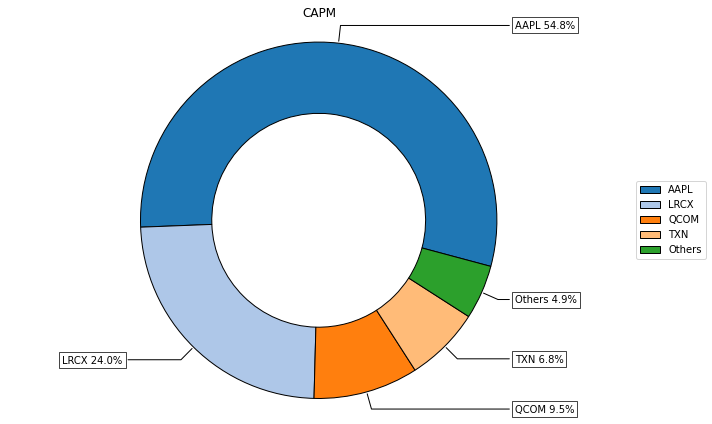

In [10]:
ax = plf.plot_pie(w=W2, title='CAPM', others=0.05, nrow = 25, cmap = "tab20", height=6, width=10, ax=None)

In [1]:
import riskfolio.Reports as rp

ax_report = rp.jupyter_report(port_diff, w=W2, rm='MV', rf=0.05, alpha=0.05, height=6, width=14,
                       others=0.05, nrow=25)

NameError: name 'port_diff' is not defined

In [12]:
################################################## ###################### 
# Calculating the vector of means and the matrix of covariances from 
# the CAPM model 
############ ################################################## ###########

# Loading the information of the factors 
#dt.date
three_factor = pd.read_csv('FF_three.csv', index_col=0, header=0)/100
three_factor = three_factor.loc[start: end][:-2]
x = three_factor[['Mkt-RF', 'SMB', 'HML']].values
#display(three_factor)
y = port_diff.values
reg = LinearRegression().fit(x, y)
B = np.matrix(reg.coef_).T

In [13]:
Sigma_F = np.cov(x.T)
error = y - reg.predict(x)
Sigma_e = np.diag(np.var(error, ddof = 1, axis = 0))

In [14]:
mu_fama = np.matrix(np.mean(reg.predict(x), axis = 0))
Sigma_fama = B.T * Sigma_F *  B + Sigma_e_2

In [15]:
w_fama_three = Max_Sharpe(mu_fama, Sigma_fama)

\\userFS\joa512\w2k\Applications\Python\Python38\site-packages\cvxpy\expressions\expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3 times so far.

  warnings.warn(msg, UserWarning)
\\userFS\joa512\w2k\Applications\Python\Python38\site-packages\cvxpy\problems\problem.py:1245: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


In [16]:
W3 = pd.DataFrame(w_fama_three, index = assets, columns = ['Fama Three'])

In [17]:
display(W3)

Fama Three
AAPL    0.258180
AVGO    0.099036
IBM     0.000003
ITW     0.183782
LRCX    0.138060
ORCL    0.051779
QCOM    0.082538
STX     0.047044
TXN     0.139577

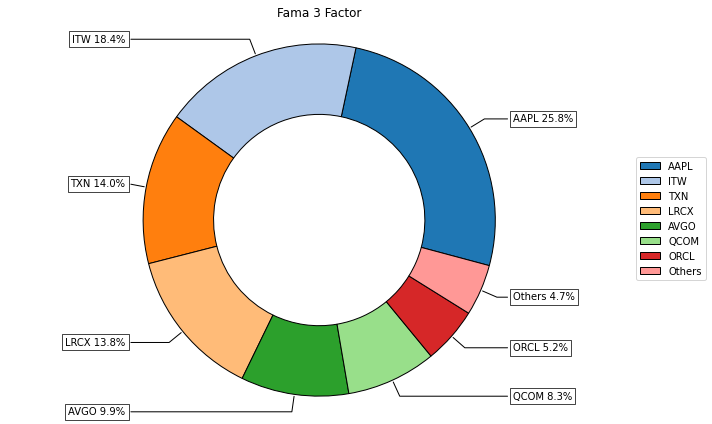

In [18]:
ax = plf.plot_pie(w=W3, title='Fama 3 Factor', others=0.05, nrow = 25, cmap = "tab20", height=6, width=10, ax=None)

\\userFS\joa512\w2k\Applications\Python\Python38\site-packages\riskfolio\RiskFunctions.py:348: RuntimeWarning: overflow encountered in exp
  value = np.mean(np.exp(-1 / z * a), axis=0)
C:\Apps\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
\\userFS\joa512\w2k\Applications\Python\Python38\site-packages\riskfolio\RiskFunctions.py:348: RuntimeWarning: overflow encountered in exp
  value = np.mean(np.exp(-1 / z * a), axis=0)
C:\Apps\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
\\userFS\joa512\w2k\Applications\Python\Python38\site-packages\riskfolio\RiskFunctions.py:348: RuntimeWarning: overflow encountered in exp
  value = np.mean(np.exp(-1 / z * a), axis=0)
C:\Apps

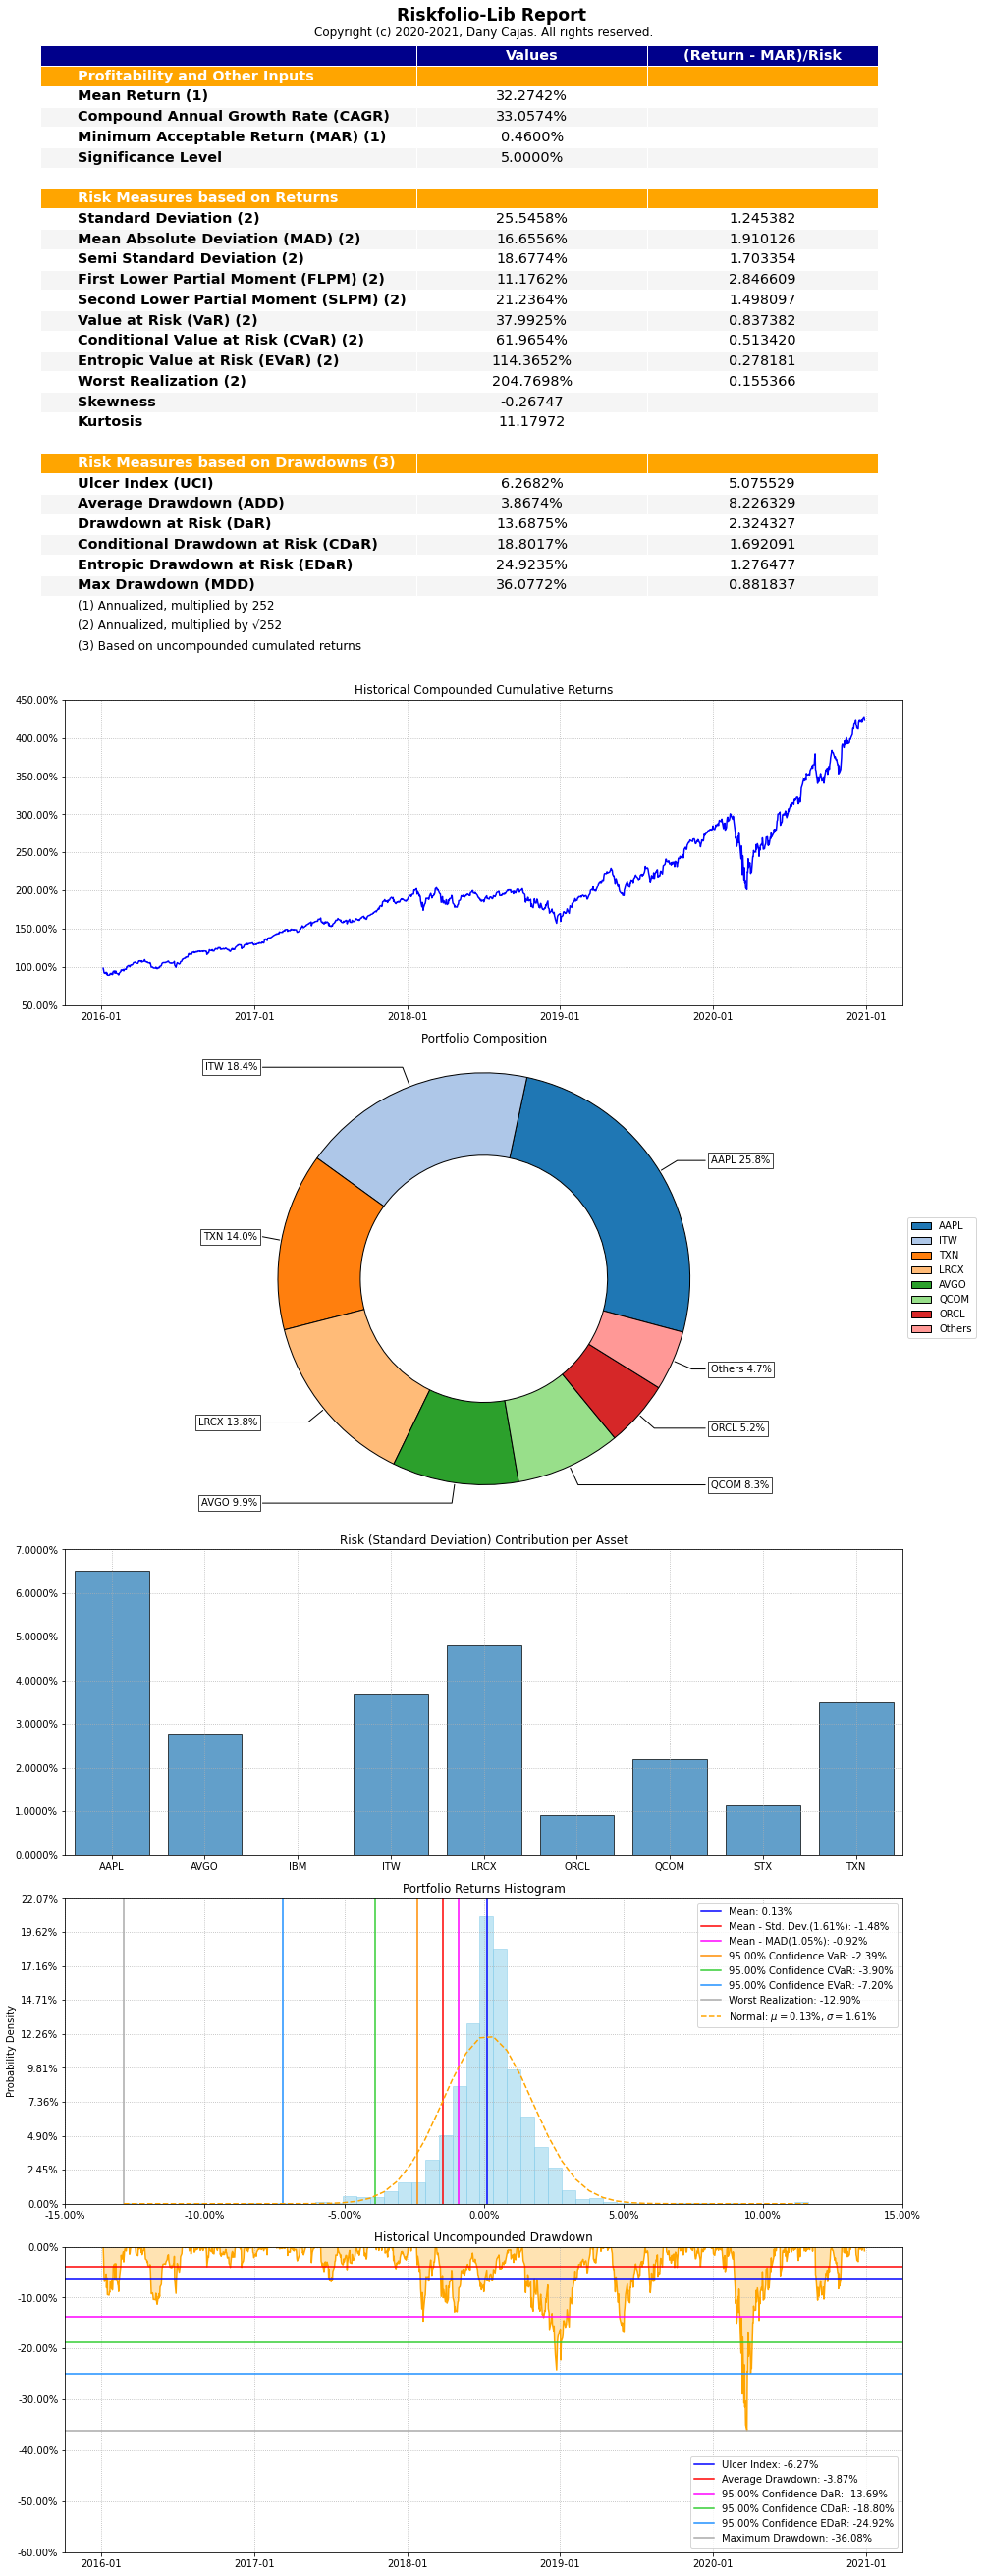

In [19]:
ax_report = rp.jupyter_report(port_diff, w=W3, rm='MV', rf=three_factor['Mkt-RF'][-1], alpha=0.05, height=6, width=14,
                       others=0.05, nrow=25)

In [20]:
five_factor = pd.read_csv('FF_five.csv', index_col=0, header=0)/100
five_factor = five_factor.loc[start: end][:-2]
x = five_factor[['Mkt-RF', 'SMB', 'HML', 'RMW','CMA']].values
y = port_diff.values
reg = LinearRegression().fit(x, y)
B = np.matrix(reg.coef_).T

In [21]:
Sigma_F = np.cov(x.T)
error = y - reg.predict(x)
Sigma_e = np.diag(np.var(error, ddof = 1, axis = 0))
mu_fama = np.matrix(np.mean(reg.predict(x), axis = 0))
Sigma_fama = B.T * Sigma_F *  B + Sigma_e_2
w_fama_five = Max_Sharpe(mu_fama, Sigma_fama)

\\userFS\joa512\w2k\Applications\Python\Python38\site-packages\cvxpy\expressions\expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 4 times so far.

  warnings.warn(msg, UserWarning)
\\userFS\joa512\w2k\Applications\Python\Python38\site-packages\cvxpy\problems\problem.py:1245: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


In [22]:
W4 = pd.DataFrame(w_fama_five, index = assets, columns = ['Fama Five'])
display(W4)

Fama Five
AAPL   0.263057
AVGO   0.097507
IBM    0.000013
ITW    0.179362
LRCX   0.138676
ORCL   0.050788
QCOM   0.082598
STX    0.046677
TXN    0.141322

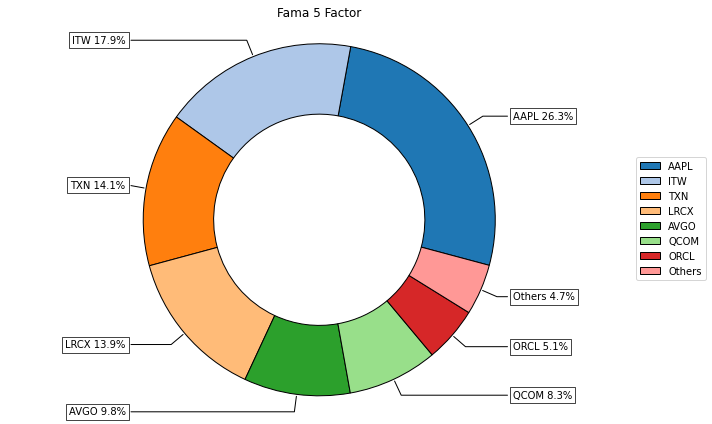

In [23]:
ax = plf.plot_pie(w=W4, title='Fama 5 Factor', others=0.05, nrow = 25, cmap = "tab20", height=6, width=10, ax=None)

C:\Apps\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
\\userFS\joa512\w2k\Applications\Python\Python38\site-packages\riskfolio\RiskFunctions.py:348: RuntimeWarning: overflow encountered in exp
  value = np.mean(np.exp(-1 / z * a), axis=0)
C:\Apps\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
\\userFS\joa512\w2k\Applications\Python\Python38\site-packages\riskfolio\RiskFunctions.py:348: RuntimeWarning: overflow encountered in exp
  value = np.mean(np.exp(-1 / z * a), axis=0)
C:\Apps\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were

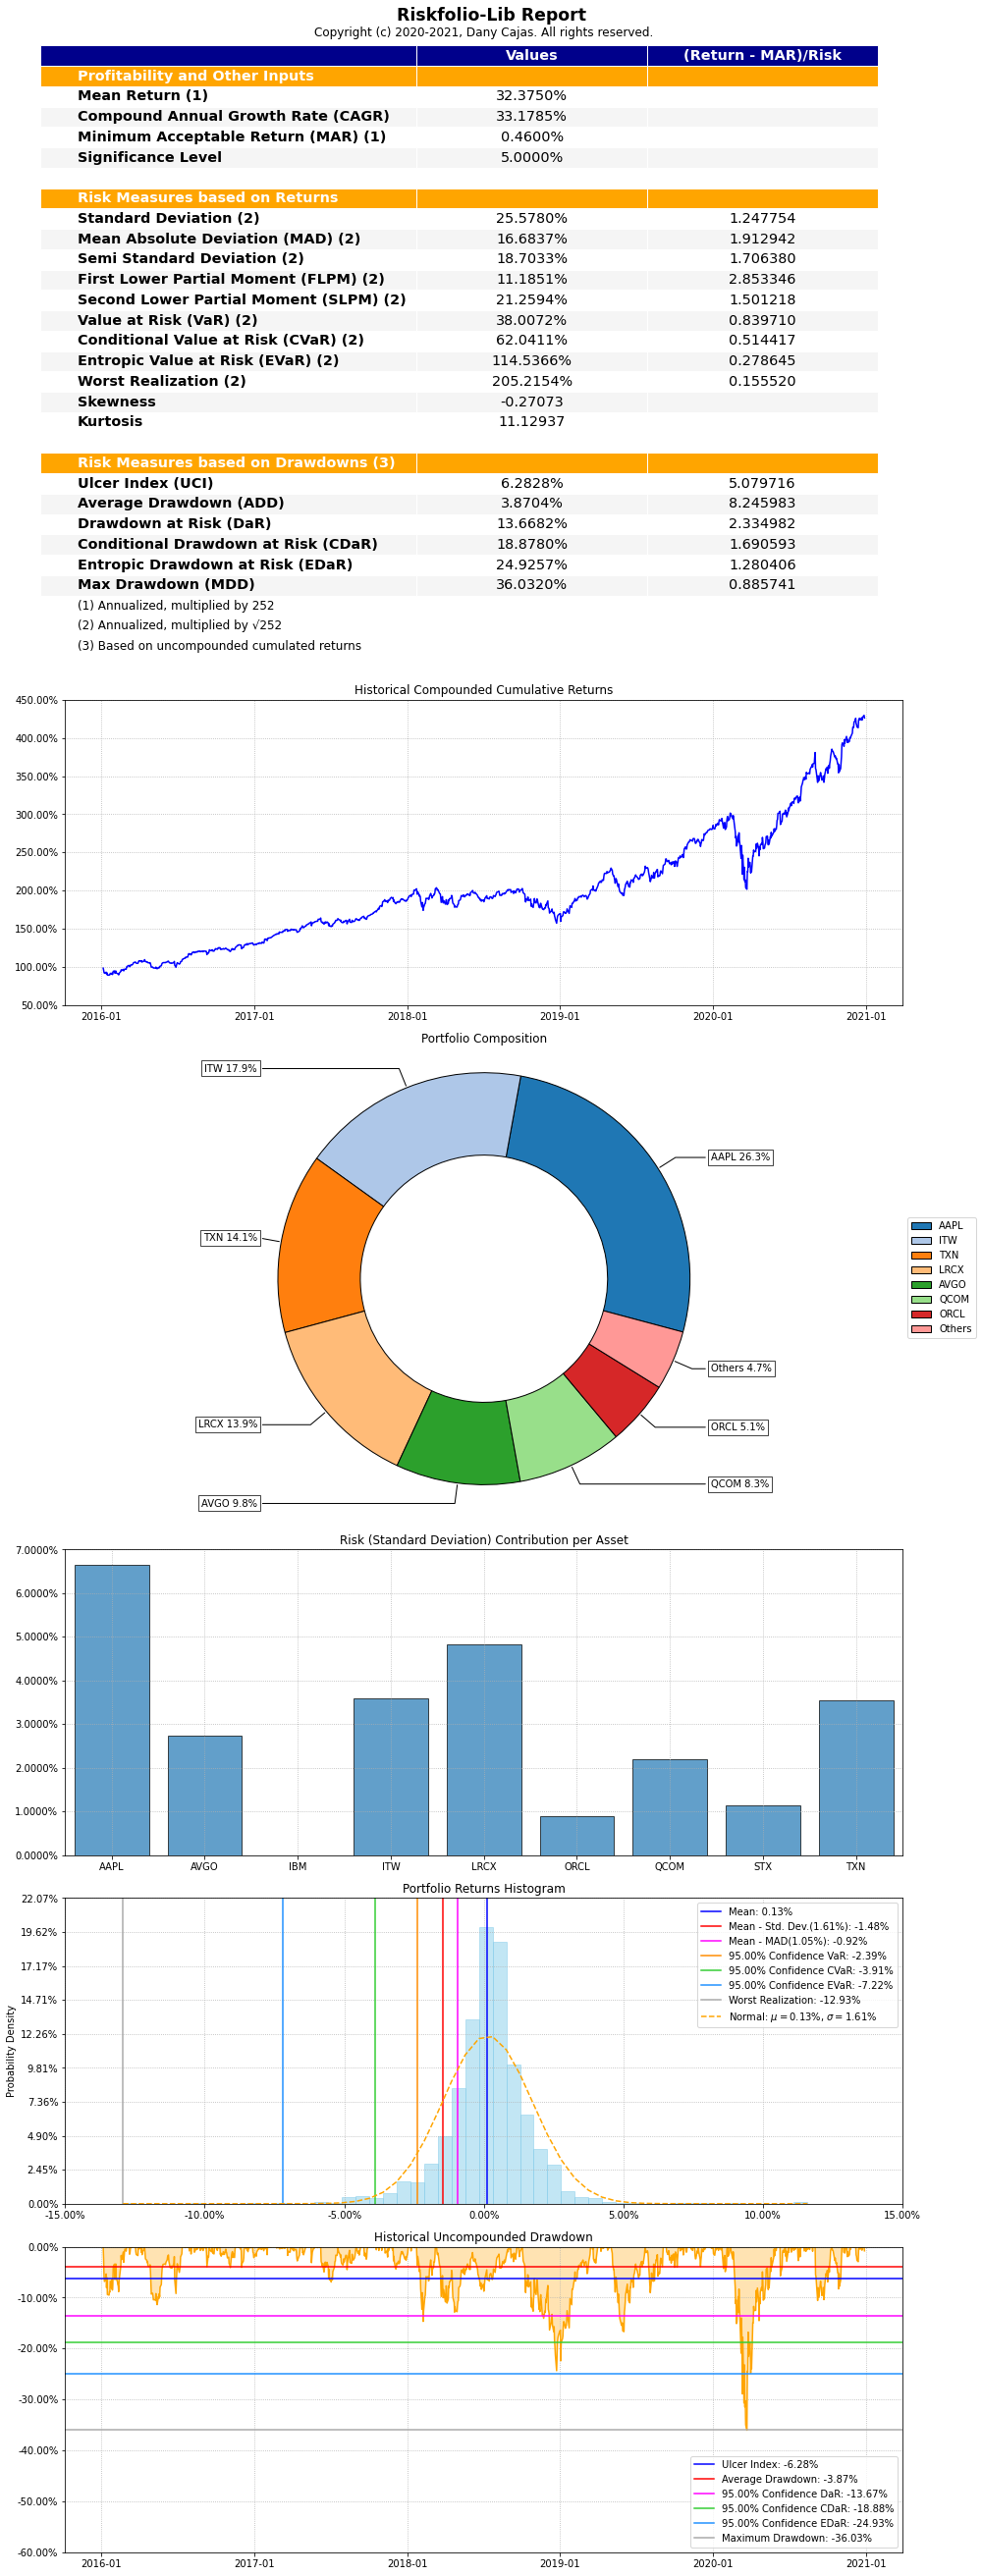

In [24]:
ax_report = rp.jupyter_report(port_diff, w=W4, rm='MV', rf=five_factor['Mkt-RF'][-1], alpha=0.05, height=6, width=14,others=0.05, nrow=25)
